In [ ]:
!pip install onnxruntime
!pip install ultralytics
!pip install imutils

  Using cached ultralytics-8.3.103-py3-none-any.whl.metadata (37 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.


image 1/1 /content/id_59_value_58_235.jpg: 640x480 213.7ms
Speed: 5.0ms preprocess, 213.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


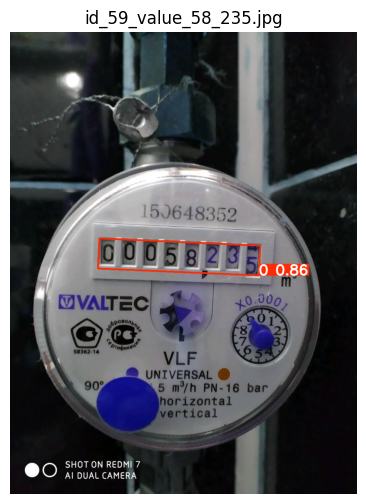

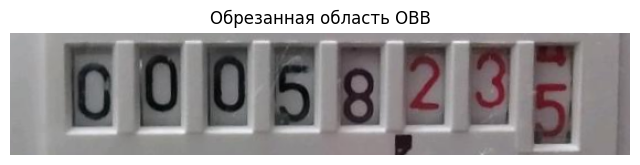

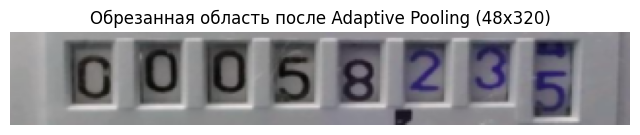

In [ ]:
import os
import cv2
import math
import torch
import numpy as np
import imutils
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Функция для расчёта углов повернутого бокса
def get_rotated_bbox_corners(center_x, center_y, width, height, rotate):
    cos_angle = np.cos(rotate)
    sin_angle = np.sin(rotate)
    half_width = width / 2
    half_height = height / 2
    corners = np.array([
        [-half_width, -half_height],
        [ half_width, -half_height],
        [ half_width,  half_height],
        [-half_width,  half_height]
    ], dtype=float)
    rotation_matrix = np.array([
        [cos_angle, -sin_angle],
        [sin_angle,  cos_angle]
    ])
    rotated_corners = np.dot(corners, rotation_matrix.T) + np.array([center_x, center_y])
    return rotated_corners

def get_crop_coords(rotated_corners):
    min_x = int(np.min(rotated_corners[:, 0]))
    min_y = int(np.min(rotated_corners[:, 1]))
    max_x = int(np.max(rotated_corners[:, 0]))
    max_y = int(np.max(rotated_corners[:, 1]))
    return min_x, min_y, max_x, max_y

def rotate_image(image, rotation):
    height, width = image.shape[:2]
    center = (width/2, height/2)
    rotation_matrix = cv2.getRotationMatrix2D(center, np.rad2deg(rotation), 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

def crop_rotate(image, center_x, center_y, width, height, rotation, dwidth=0):
    rotated_image = rotate_image(image, rotation)
    rotated_corners = get_rotated_bbox_corners(center_x, center_y, width + dwidth, height, rotation)
    min_x, min_y, max_x, max_y = get_crop_coords(rotated_corners)
    cropped_image = rotated_image[min_y:max_y, min_x:max_x]
    return cropped_image

def crop_rotate_obb(obb_object):
    # Предполагается, что obb_object.obb.xywhr[0] содержит [x_center, y_center, w, h, theta]
    # Если угол в радианах, оставляем как есть; если в градусах, сконвертируйте в радианы.
    obb = obb_object.obb.xywhr[0].cpu().numpy()  # [x, y, w, h, theta]
    center_x, center_y, width, height, theta = obb
    # Если theta в градусах, можно конвертировать: theta = np.deg2rad(theta)
    cropped = crop_rotate(obb_object.orig_img, center_x, center_y, width, height, theta, dwidth=width*0.2)
    return cropped

# Загрузка модели YOLOv8-OBB (путь можно подстроить)
model_path = 'best.pt'
yolo_model = YOLO(model_path)

# Пример предсказания на одном изображении (измените путь на нужный)
image_path = '/content/id_59_value_58_235.jpg'
preds = yolo_model.predict(source=image_path, conf=0.75, max_det=1, save=False)

# Отображаем предсказанный ориентированный bbox на исходном изображении
plt.figure(figsize=(8,6))
plt.imshow(preds[0].plot())
plt.title(os.path.basename(image_path))
plt.axis('off')
plt.show()

# Применяем функцию crop_rotate_obb для обрезки области
cropped_img = crop_rotate_obb(preds[0])
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
plt.title("Обрезанная область OBB")
plt.axis('off')
plt.show()

# Приводим обрезанное изображение к размеру 320x48 с помощью адаптивного пуллинга
layer = torch.nn.AdaptiveAvgPool2d((48, 320))
# Преобразуем изображение в тензор и нормализуем (HWC -> CHW)
t_img = torch.tensor(cropped_img.transpose((2, 0, 1))).unsqueeze(0).float() / 255.
t_resized = layer(t_img)
resized_np = t_resized.squeeze(0).permute(1,2,0).detach().numpy()

plt.figure(figsize=(8,3))
plt.imshow(resized_np)
plt.title("Обрезанная область после Adaptive Pooling (48x320)")
plt.axis('off')
plt.show()


WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading model.onnx for ONNX Runtime inference...
Using ONNX Runtime CPUExecutionProvider

image 1/1 /content/id_59_value_58_235.jpg: 640x480 1 0, 174.1ms
Speed: 7.4ms preprocess, 174.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


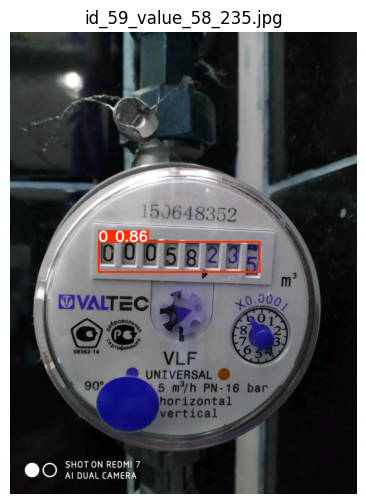

Данные OBB отсутствуют. Используем стандартный ограничивающий прямоугольник.


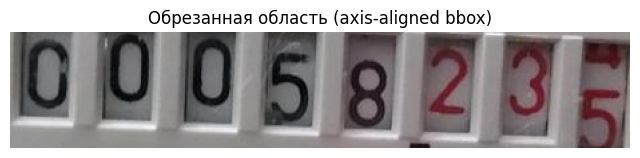

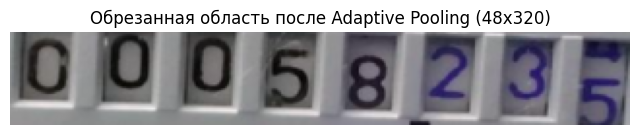

In [ ]:
import os
import cv2
import math
import torch
import numpy as np
import imutils
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Функция для расчёта углов повернутого бокса
def get_rotated_bbox_corners(center_x, center_y, width, height, rotate):
    cos_angle = np.cos(rotate)
    sin_angle = np.sin(rotate)
    half_width = width / 2
    half_height = height / 2
    corners = np.array([
        [-half_width, -half_height],
        [ half_width, -half_height],
        [ half_width,  half_height],
        [-half_width,  half_height]
    ], dtype=float)
    rotation_matrix = np.array([
        [cos_angle, -sin_angle],
        [sin_angle,  cos_angle]
    ])
    rotated_corners = np.dot(corners, rotation_matrix.T) + np.array([center_x, center_y])
    return rotated_corners

def get_crop_coords(rotated_corners):
    min_x = int(np.min(rotated_corners[:, 0]))
    min_y = int(np.min(rotated_corners[:, 1]))
    max_x = int(np.max(rotated_corners[:, 0]))
    max_y = int(np.max(rotated_corners[:, 1]))
    return min_x, min_y, max_x, max_y

def rotate_image(image, rotation):
    height, width = image.shape[:2]
    center = (width / 2, height / 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, np.rad2deg(rotation), 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

def crop_rotate(image, center_x, center_y, width, height, rotation, dwidth=0):
    rotated_image = rotate_image(image, rotation)
    rotated_corners = get_rotated_bbox_corners(center_x, center_y, width + dwidth, height, rotation)
    min_x, min_y, max_x, max_y = get_crop_coords(rotated_corners)
    cropped_image = rotated_image[min_y:max_y, min_x:max_x]
    return cropped_image

def crop_rotate_obb(obb_object):
    # Предполагается, что obb_object.obb.xywhr[0] содержит [x_center, y_center, w, h, theta]
    if obb_object.obb is None:
        raise ValueError("Данные OBB отсутствуют в предсказании.")
    obb = obb_object.obb.xywhr[0].cpu().numpy()  # [x, y, w, h, theta]
    center_x, center_y, width, height, theta = obb
    # Если угол в градусах, можно сконвертировать: theta = np.deg2rad(theta)
    cropped = crop_rotate(obb_object.orig_img, center_x, center_y, width, height, theta, dwidth=width * 0.2)
    return cropped

# Загрузка модели YOLOv8-OBB (путь можно подстроить)
model_path = 'model.onnx'
yolo_model = YOLO(model_path)

# Пример предсказания на одном изображении (измените путь на нужный)
image_path = '/content/id_59_value_58_235.jpg'
preds = yolo_model.predict(source=image_path, conf=0.75, max_det=1, save=False)

# Отображаем предсказанный bbox на исходном изображении
plt.figure(figsize=(8, 6))
plt.imshow(preds[0].plot())
plt.title(os.path.basename(image_path))
plt.axis('off')
plt.show()

# Проверяем наличие данных OBB
if preds[0].obb is not None:
    # Если данные OBB есть, используем их для обрезки
    cropped_img = crop_rotate_obb(preds[0])
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    plt.title("Обрезанная область OBB")
    plt.axis('off')
    plt.show()
else:
    # Если данных OBB нет, используем стандартный axis-aligned bbox
    print("Данные OBB отсутствуют. Используем стандартный ограничивающий прямоугольник.")
    # Извлекаем координаты axis-aligned bbox (x1, y1, x2, y2)
    bbox = preds[0].boxes.xyxy[0].cpu().numpy()  # предполагается, что есть атрибут boxes
    x1, y1, x2, y2 = bbox.astype(int)
    cropped_img = preds[0].orig_img[y1:y2, x1:x2]
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    plt.title("Обрезанная область (axis-aligned bbox)")
    plt.axis('off')
    plt.show()

# Приводим обрезанное изображение к размеру 320x48 с помощью адаптивного пуллинга
layer = torch.nn.AdaptiveAvgPool2d((48, 320))
# Преобразуем изображение в тензор и нормализуем (HWC -> CHW)
t_img = torch.tensor(cropped_img.transpose((2, 0, 1))).unsqueeze(0).float() / 255.
t_resized = layer(t_img)
resized_np = t_resized.squeeze(0).permute(1, 2, 0).detach().numpy()

plt.figure(figsize=(8, 3))
plt.imshow(resized_np)
plt.title("Обрезанная область после Adaptive Pooling (48x320)")
plt.axis('off')
plt.show()
